### Results

Check the [report.pdf file](report.pdf) for the results.

### Install required dependencies

In [ ]:
!pip install numpy matplotlib

### Load dataset

In [2]:
import numpy as np

# I took this function from tutorials
def prepare_data(filename):
    patterns = []
    with open(filename) as f:
        count, width, height = [int(x) for x in f.readline().split()] # header
        dim = width*height

        for _ in range(count):
            f.readline() # skip empty line
            x = np.empty((height, width))
            for r in range(height):
                x[r,:] = np.array(list(f.readline().strip())) == '#'
            patterns.append(2*x.flatten()-1) # flatten to 1D vector, rescale {0,1} -> {-1,+1}
    
    return patterns, dim

patterns, dim = prepare_data('data.in')
labels = ['X', 'H', 'O', 'Z']

### Corrupt pattern function

In [3]:
def corrupt_patterns(patterns, k):
    corrupted_patterns = []
    for p in patterns:
        cp = np.copy(p)
        indices_to_flip = np.random.choice(len(p), size=k, replace=False)
        cp[indices_to_flip] *= -1
        corrupted_patterns.append(cp)
    return corrupted_patterns

### Train hopfield network

In [4]:
from hopfield import HopfieldNetwork

network = HopfieldNetwork(dim)
network.train(patterns)

### Store results for plotting

In [5]:
results = {}
overlaps = {}
k_noises = [0, 7, 14, 21]
for k in k_noises:
    corrupted_patterns = corrupt_patterns(patterns, k) if k > 0 else list(patterns)
    results[k] = []
    overlaps[k] = [[[] for _ in range (len(patterns))] for _ in range(len(patterns))]
    
    for cpi, cp in enumerate(corrupted_patterns):
        states, energies, _ = network.run_sync(cp)
        for state in states:
            for pi in range(len(patterns)):
                overlaps[k][cpi][pi].append(np.sum(state == patterns[pi]) / len(state))
        results[k].append((states, energies))

### Plot results

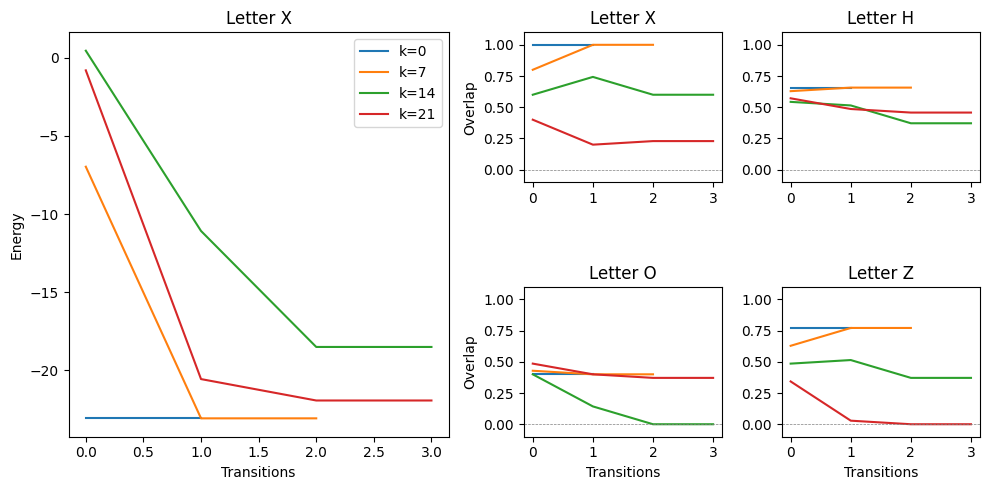

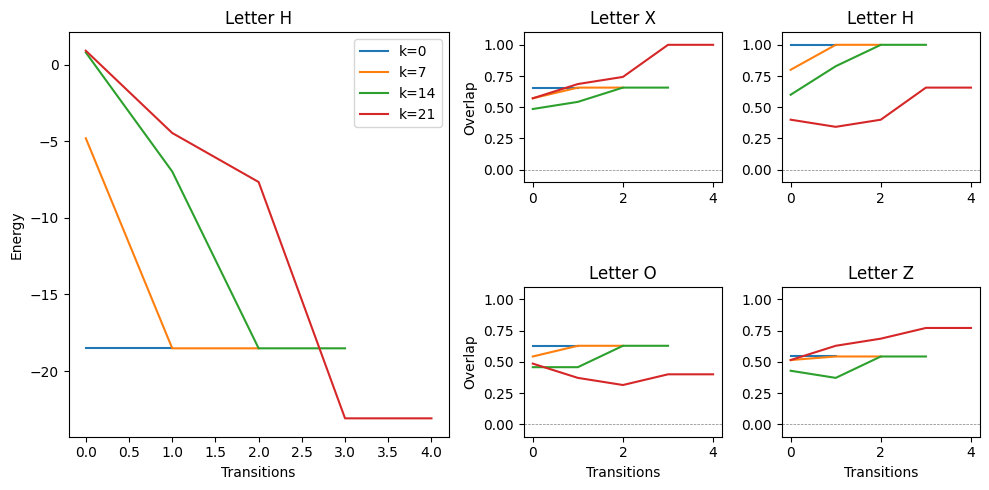

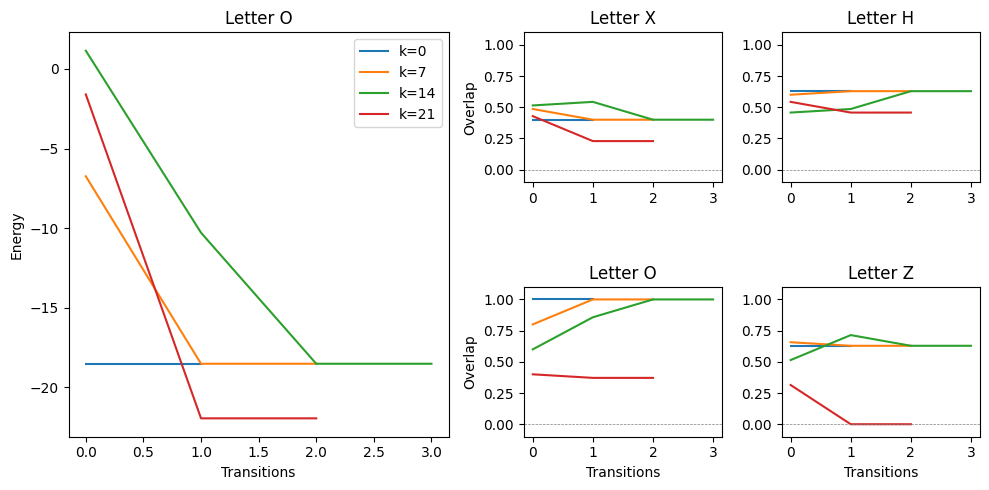

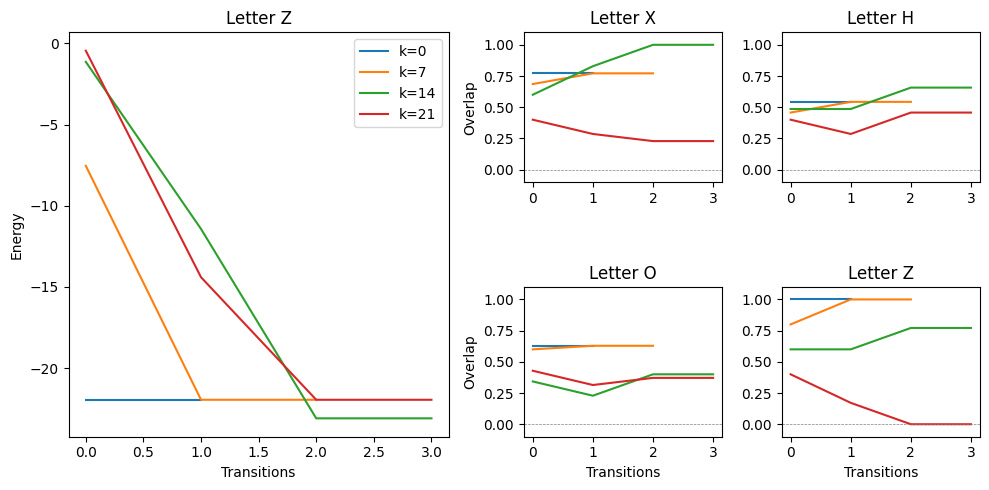

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

for letter_index in range(len(patterns)): 

    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Letter {labels[letter_index]}')
    ax0.set_xlabel('Transitions')
    ax0.set_ylabel('Energy')

    data = [results[k][letter_index] for k in k_noises]
    for i, (states, energies) in enumerate(data):
        ax0.plot(energies, label=f'k={k_noises[i]}')
    ax0.legend()
    
    gs_right = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1], wspace=0.3, hspace=0.7)

    for i in range(len(patterns)):
        ax = plt.subplot(gs_right[i])
        ax.set_title(f'Letter {labels[i]}')
        ax.set_ylim(-0.1,1.1)
        if i%2 == 0:
            ax.set_ylabel('Overlap')
        if i == 2 or i==3:
            ax.set_xlabel('Transitions')
        for ki, k in enumerate(k_noises):
            overlap_curve = overlaps[k][letter_index][i]
            ax.plot(overlap_curve, label=f'k={k}')
        ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    fig.savefig(f'letter_{labels[letter_index]}_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

## 10000 random

In [7]:
from collections import defaultdict

ta_count = 0
fa_count = 0
lc_count = 0
most_frequent = defaultdict(int)

for i in range(10000):
    if i % 100 == 0:
        print(f'Iteration {i}')
    rp = np.random.choice([-1, 1], size=35)
    states, energies, is_fixed_point = network.run_sync(rp)
    final_state = states[-1]
    
    if not is_fixed_point:
        lc_count += 1
    else:
        true_attractor = False
        for p in patterns:
            if np.all(final_state == p) or np.all(final_state == -p):
                true_attractor = True
                break
            
        if true_attractor:
            ta_count += 1
        else:
            fa_count += 1

    if final_state[0] == -1:
        final_state *= -1
    
    most_frequent[tuple(final_state)] += 1
    
print(f'True attractors: {ta_count}')
print(f'False attractors: {fa_count}')
print(f'Limit cycles: {lc_count}')

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700
Iteration 1800
Iteration 1900
Iteration 2000
Iteration 2100
Iteration 2200
Iteration 2300
Iteration 2400
Iteration 2500
Iteration 2600
Iteration 2700
Iteration 2800
Iteration 2900
Iteration 3000
Iteration 3100
Iteration 3200
Iteration 3300
Iteration 3400
Iteration 3500
Iteration 3600
Iteration 3700
Iteration 3800
Iteration 3900
Iteration 4000
Iteration 4100
Iteration 4200
Iteration 4300
Iteration 4400
Iteration 4500
Iteration 4600
Iteration 4700
Iteration 4800
Iteration 4900
Iteration 5000
Iteration 5100
Iteration 5200
Iteration 5300
Iteration 5400
Iteration 5500
Iteration 5600
Iteration 5700
Iteration 5800
Iteration 5900
Iteration 6000
Iteration 6100
Iteration 6200
Iteration 6300
Iteration 6400
Iteration 6500
Iteration 6600
Iterati

### Plot distribution of true attractors, false attractors and limit cycles

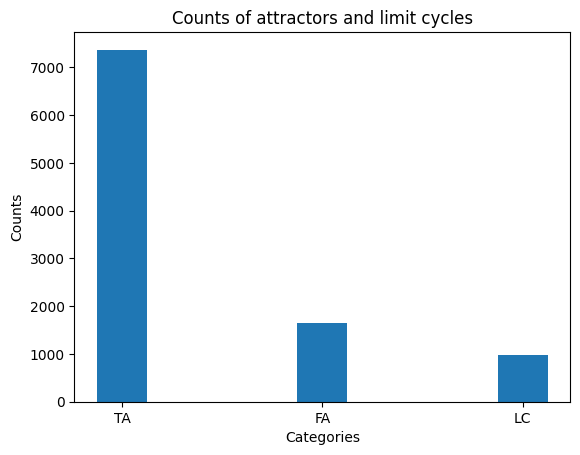

In [8]:
import matplotlib.pyplot as plt


# Data for the bar plot
counts = [ta_count, fa_count, lc_count]
labels = ['TA', 'FA', 'LC']

# Create bar plot
plt.bar(range(len(counts)), counts, width=0.25 , align='center', tick_label=labels)

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Counts of attractors and limit cycles')

# Save the plot with increased DPI
plt.savefig('counts_bar_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Plot 10 most frequent states

map size 89


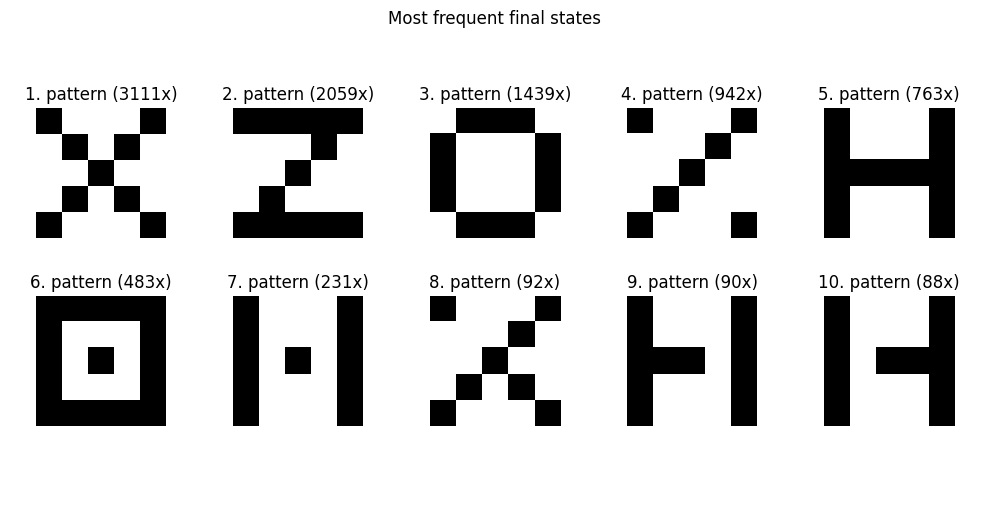

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.title('Most frequent final states')
plt.axis('off')
print('map size', len(most_frequent))

for i, (key, val) in enumerate(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True)[:10]):
    plt.subplot(2, 5, i+1)
    plt.title(f'{i+1}. pattern ({val}x)')
    plt.imshow(np.array(key).reshape(5, 7), cmap='gray')
    plt.axis('off')
    plt.tight_layout()

plt.savefig('most_frequent_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

### Bonus

##### 4 letters

In [17]:
from collections import defaultdict 

patterns, dim = prepare_data('data.in')
network = HopfieldNetwork(dim)
network.train(patterns)

four_patterns_recall = defaultdict(int)
for k in k_noises:
    for i in range(250):
        corrupted_patterns = corrupt_patterns(patterns, k) if k > 0 else list(patterns)
        for i, cp in enumerate(corrupted_patterns):
            states, energies, _ = network.run_sync(cp)
            final_state = states[-1]
            if np.array_equal(final_state, patterns[i]) or np.array_equal(final_state, -patterns[i]):
                four_patterns_recall[k] += 1

##### 6 letters

In [ ]:
from collections import defaultdict

patterns, dim = prepare_data('bonus_data_6.in')
network = HopfieldNetwork(dim)
network.train(patterns)

six_patterns_recall = defaultdict(int)
for k in k_noises:
    for i in range(167):
        corrupted_patterns = corrupt_patterns(patterns, k) if k > 0 else list(patterns)
        for i, cp in enumerate(corrupted_patterns):
            states, energies, _ = network.run_sync(cp)
            final_state = states[-1]
            if np.array_equal(final_state, patterns[i]) or np.array_equal(final_state, -patterns[i]):
                six_patterns_recall[k] += 1

##### 8 letters

In [18]:
from collections import defaultdict

patterns, dim = prepare_data('bonus_data_8.in')
network = HopfieldNetwork(dim)
network.train(patterns)

eight_patterns_recall = defaultdict(int)
for k in k_noises:
    for _ in range(125):
        corrupted_patterns = corrupt_patterns(patterns, k) if k > 0 else list(patterns)
        for i, cp in enumerate(corrupted_patterns):
            states, energies, _ = network.run_sync(cp)
            final_state = states[-1]
            if np.array_equal(final_state, patterns[i]) or np.array_equal(final_state, -patterns[i]):
                eight_patterns_recall[k] += 1

#### Plot results

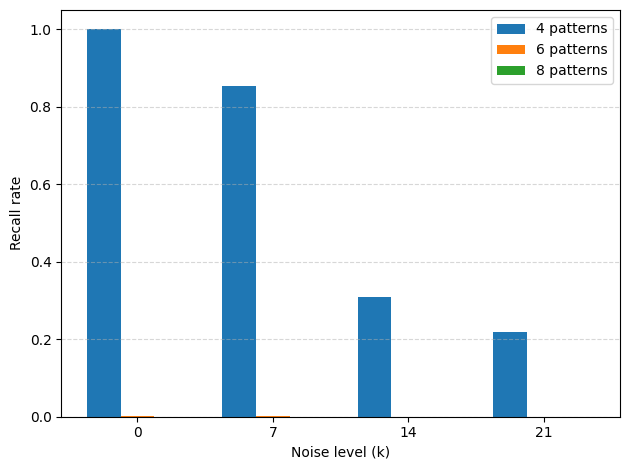

In [20]:
import numpy as np
import matplotlib.pyplot as plt

k_res = [
    (four_patterns_recall[k]/(250*4),# 1000 samples
     six_patterns_recall[k]/(167*6), # 1002 samples
     eight_patterns_recall[k]/(125*8)) # 1000 samples
    for k in k_noises
]

x = np.arange(len(k_noises))
width = 0.25

plt.bar(x - width, [r[0] for r in k_res], width, label='4 patterns')
plt.bar(x, [r[1] for r in k_res], width, label='6 patterns')
plt.bar(x + width, [r[2] for r in k_res], width, label='8 patterns')

plt.xticks(x, k_noises)
plt.xlabel('Noise level (k)')
plt.ylabel('Recall rate')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('recall_ratek.png', dpi=300, bbox_inches='tight')
plt.show()